In [2]:
from matplotlib import pyplot as plt
import os
import csv
import pandas as pd
import numpy as np
import cv2


In [3]:
file_path = 'hand_labels_hsv_train_float_fixed.csv'

df = pd.read_csv(file_path)

# removing 1st column containing label name ('orange cone')
df = df.drop(df.columns[0], axis=1)

original_data = df.to_numpy(dtype=np.float64)

# data with shifted hue value
df['SH'] = (df['H'] + 90) % 180
input_data = df[['SH', 'S', 'V']].to_numpy(dtype=np.float64)
# df = df[['SH', 'S', 'V']]
# print(df.head())
print(input_data)

[[ 91.8881115 239.9012715 152.0000073]
 [ 91.8881115 241.4900235 151.0000095]
 [ 92.0270265 234.4098975 161.000013 ]
 ...
 [ 89.370635  151.3070448 241.0000002]
 [ 89.7973    151.566237  249.000003 ]
 [ 91.1764703 154.821414  252.0000015]]


In [4]:
### Combining training and val data #####
file_path1 = 'hand_labels_hsv_val_float_fixed.csv'

df1 = pd.read_csv(file_path1)

# removing 1st column containing label name ('orange cone')
df1 = df1.drop(df1.columns[0], axis=1)

original_val_data = df1.to_numpy(dtype=np.float64)

# data with shifted hue value
df1['SH'] = (df1['H'] + 90) % 180
val_data = df1[['SH', 'S', 'V']].to_numpy(dtype=np.float64)
# df = df[['SH', 'S', 'V']]
# print(df.head())
print(val_data)

combined_data = np.concatenate((input_data, val_data), axis=0)

print(combined_data.shape)


[[ 92.3463688  188.6156715  241.999998  ]
 [ 92.3463688  189.3983175  241.0000002 ]
 [ 92.35955025 187.56194775 241.999998  ]
 ...
 [ 89.6        239.062449   160.000005  ]
 [ 89.59732    243.55764    155.9999985 ]
 [ 89.59732    248.33328765 153.        ]]
(53152, 3)


(53152, 3)


In [5]:
from scipy.stats import multivariate_normal #### ONLY USED FOR TESTING ####


In [6]:
##### computing the log normal pdf (currently unused) #########
def log_gaussians(xs, mus, Sigmas):
    """
    xs: n x d array
    mus: k x d array
    Sigmas: k x d x d array
    """
    n, d = xs.shape
    k = mus.shape[0]
    
    # determinant and inverse Sigmas
    Sigma_det = np.linalg.det(Sigmas)
    Sigma_inv = np.linalg.inv(Sigmas)
    
    # constant parts of log PDF
    constant_term = -0.5 * d * np.log(2 * np.pi) - 0.5 * np.log(Sigma_det)
        
    # exponent term for each Gaussian
    exponent_terms = np.empty((n, k))
    for k_i in range(k):
        diffs = xs - mus[k_i]
        print("diffs shape: ", np.shape(diffs))
        exponent_terms[:, k_i] = -0.5 * np.sum(diffs @ Sigma_inv[k_i] * diffs, axis=1)
    
    assert np.shape(exponent_terms) == (n, k)
    
    log_pdf = exponent_terms + constant_term
    return log_pdf

In [7]:
### High dimenisonal Gaussian ###
def gaussian(xs, mus, Sigmas, n, k):
    """
    xs: n x 3 array
    mus: k x 3 array
    Sigmas: k x 3 x 3 array

    Returns:
    - Array g with shape (n, k), whre g[i, j] is pdf of sample i in Gaussian j
    """
    assert np.shape(xs) == (n, 3)
    assert np.shape(mus) == (k, 3)
    assert np.shape(Sigmas) == (k, 3, 3)

    # determinant and inverse Sigmas
    Sigma_det = np.linalg.det(Sigmas)
    Sigma_inv = np.linalg.inv(Sigmas)

    # calculate coefficient terms for gaussians
    coef = 1 / np.sqrt(((2 * np.pi) ** 3) * Sigma_det)
    # print("coef shape: ", np.shape(coef))
    coef = np.reshape(coef, (k, 1))
    assert np.shape(coef) == (k, 1)

    # exponent term
    # diffs = xs[:, np.newaxis, :] - mus  # Shape (n, k, 3),
    diffs = xs.reshape(n, 1, 3) - mus  # Shape (n, k, 3),
    assert np.shape(diffs) == (n, k, 3)
    exponent_terms = -0.5 * (np.reshape(diffs, (n, k, 1, 3)) @ Sigma_inv \
                             @ np.reshape(diffs, (n, k, 3, 1))) # TODO: see if we need to smooth inverse sigma
    # diffs
    # dSd = diffs @ Sigma_inv 
    # dSd = dSd * diffs
    # exponent_terms = -0.5 * np.sum(dSd, axis=2)  # Shape (n, k)
    # exponent_terms = np.zeros((n, k))
    # for i in range(k):
    #     diffs = xs - mus[i]  # Shape (n, 3), broadcasting xs over mus[i]
    #     # Use einsum for the quadratic form (x-mu).T Sigma_inv (x-mu)
    #     exponent_terms[:, i] = -0.5 * np.sum(diffs @ Sigma_inv * diffs, axis=2)

    # print("exponent terms shape: ", np.shape(exponent_terms))
    exponent_terms = exponent_terms.reshape(n, k)
    assert np.shape(exponent_terms) == (n, k)

    # put it all together
    # print("exponent terms: ", exponent_terms)
    g = np.exp(exponent_terms) * coef.T
    assert np.shape(g) == (n, k)
    
    return g  

    ##### old implementation #######
    # assert np.shape(xs) == (n, 3)
    # assert np.shape(mus) == (k, 3)
    # assert np.shape(Sigmas) == (k, 3, 3)

    # # determinant and inverse Sigmas
    # Sigma_det = np.linalg.det(Sigmas)
    # Sigma_inv = np.linalg.inv(Sigmas)

    # # calculate coefficient terms for gaussians
    # coef = np.sqrt((2 * np.pi) ** 3 * Sigma_det)
    # print("coef shape: ", np.shape(coef))
    # coef = np.reshape(coef, (k, 1))
    # assert np.shape(coef) == (k, 1)

    # # exponent term
    # diffs = np.reshape(xs, (n, 1, 3)) - np.reshape(mus, (1, k, 3))
    # assert np.shape(diffs) == (n, k, 3)
    # exponent_terms = -0.5 * (np.reshape(diffs, (n, k, 1, 3)) @ Sigma_inv \
    #                          @ np.reshape(diffs, (n, k, 3, 1)))
    # print("exponent terms shape: ", np.shape(exponent_terms))
    # assert np.shape(exponent_terms) == (n, k, 1, 1)

    # # put it all together
    # exponent_terms = np.reshape(exponent_terms, (n, k))
    # coef = coef.T
    # print("exponent terms: ", exponent_terms)
    # g = np.exp(exponent_terms) / coef
    # assert np.shape(g) == (n, k)
    
    # return g    

xs_test = np.array([[1, 2, 3], [4, 5, 6]])
mus_test = np.array([[0, 0, 0], [5, 5, 5]])
Sigmas_test = np.array([np.eye(3), np.eye(3)])
n_test = 2
k_test = 2 

print("input solution: ")
print(gaussian(xs_test, mus_test, Sigmas_test, n_test, k_test))
print("expected solution for top right: ")
print(multivariate_normal.pdf([1, 2 ,3], mean=[5, 5, 5], cov=np.eye(3)))
print("expected solution for bottom right: ")
print(multivariate_normal.pdf([4, 5, 6], mean=[5, 5, 5], cov=np.eye(3)))

# old version of lower dimensional gaussian function

def gaussian3x3(x, mu, sigma):
    """
    x : length 3 numpy input vector
    mu: length 3 numpy vector
    sigma: 3x3 numpy vector
    """
    # k = mu.shape[0]
    Sigma_det = np.linalg.det(sigma)
    Sigma_inv = np.linalg.inv(sigma)
    coef = np.sqrt((2 * np.pi) ** 3 * Sigma_det)
    
    diff = x - mu
    # exponent_term = -0.5 * np.dot(np.dot(diff.T, Sigma_inv), diff)
    exponent_term = -0.5 * (diff.T @ Sigma_inv @ diff)
    
    return np.exp(exponent_term) / coef

input solution: 
[[5.78987015e-05 3.20228669e-08]
 [1.20890631e-18 2.33580033e-02]]
expected solution for top right: 
3.202286687137089e-08
expected solution for bottom right: 
0.02335800330543158


In [8]:
def calculate_sigma_k(X, mu_k, z, z_k):
    """
    covariance matrix for the k-th Gaussian component

    Parameters:
    X : n x d array
    mu_k : (d,) array
    z: (n,) array - responsibility for each pixel in X
    z_k : constant - sum of elements in z

    Returns:
    sigma_k : d x d
    """
    
    # Ensure mu_k is a column vector
    # mu_k = mu_k.reshape(-1, 1)
    # Calculate the deviation of each data point from the mean
    diff = X - mu_k.T
    print("diff shape: ", diff.shape)
    weighted_deviation = np.reshape(z, (-1, 1)) * diff # TODO: maybe use np.cov here?
    sigma_k = weighted_deviation.T @ diff
    sigma_k /= z_k
    
    return sigma_k

# for testing sigma_k:
X = np.array([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])  # Example data points
mu_k = np.array([2.5, 3.5])  # Example mean for Gaussian k
z_k = np.array([0.5, 1.5, 0.5])  # Example responsibilities for Gaussian k
sigma_k = calculate_sigma_k(X, mu_k, z_k, z_k.sum())
print(sigma_k)

diff shape:  (3, 2)
[[1.85 1.85]
 [1.85 1.85]]


In [9]:
# Likelihood objective function
# def calc_likelihood(inputs, mus, Sigmas, weights):
#     """
#     log-likelihood function for GMM

#     Parameters:
#     X : n x d array
#     mus : k x 3 array
#     Sigmas: k x 3 x 3 array
#     weights: n x d array - responsibility for each pixel in X

#     Returns:
#     likelihood: float
#     """

def calc_loglikelihood_g(gaussians, weights, use_weights=False):
    """
    log-likelihood function for GMM

    Parameters:
    gaussians: Array g with shape (n, k), whre g[i, j] is pdf of sample i in Gaussian j
    weights: n x k array - responsibility for each pixel in X

    Returns:
    likelihood: float
    """
    n, k = np.shape(gaussians)
    if use_weights:
        assert gaussians.shape[0] == weights.shape[0]
        # NOTE: this is unimplemented, not taught in class
        inner_sum = np.sum(gaussians, axis=1)
        print("inner sum shape: ", inner_sum.shape)
        L = np.sum(np.log(inner_sum), axis=0)
        print("Likelihood: ", L)
        return L
    else:
        inner_sum = np.sum(gaussians, axis=1) / k
        print("inner sum shape: ", inner_sum.shape)
        L = np.sum(np.log(inner_sum), axis=0)
        print("Likelihood: ", L)
        return L


    

In [10]:
### scoring code for prediction ####
def predict_likelihood_g(x, mus, Sigmas) -> np.float64:
    # print("x.shape", x.shape)
    assert x.shape == (1, 3)
    k = mus.shape[0]
    ans = gaussian(x, mus, Sigmas, 1, k)
    ans = np.sum(ans, axis= -1) / k
    # print("prediction: ", ans)
    return ans
    # return np.exp(ans, dtype=np.float64)


In [11]:
##### Lookup table code (6-bit) ########

# Convert HSV values to 6-bit equivalents
def hsv_to_6bit(h, s, v):
    h_5bit = int((h / 180.0) * 63)  # Hue range of 0-180
    s_5bit = int((s / 255.0) * 63)  # Saturation range of 0-255
    v_5bit = int((v / 255.0) * 63)  # Value range of 0-255
    return h_5bit, s_5bit, v_5bit

def six_bit_to_hsv(h_5bit, s_5bit, v_5bit):
    # Convert back from 5-bit to original HSV scale
    h = (h_5bit / 63.0) * 180  
    s = (s_5bit / 63.0) * 255 
    v = (v_5bit / 63.0) * 255
    return h, s, v

# Function to initialize the 64x64x64 lookup table
def create_lookup_table(mus, Sigmas):
    lookup_table = np.zeros((64, 64, 64), dtype=np.float64)  # Using float64 to maintain small values
    for h5 in range(64):
        for s5 in range(64):
            for v5 in range(64):
                h, s, v = six_bit_to_hsv(h5, s5, v5)
                ### NOTE: first shifting hue 90 degrees up to account for shift
                h = (h + 90) % 180

                x = np.array([h, s, v], dtype=np.float64).reshape(1, 3)
                # filling in the lookup table with sum of gaussian pdf values
                lookup_table[h5, s5, v5] = predict_likelihood_g(x, mus, Sigmas)[0]
    return lookup_table

# Function to query the lookup table with HSV values
def query_lookup_table(h, s, v, lookup_table):
    h_5bit, s_5bit, v_5bit = hsv_to_6bit(h, s, v)
    return lookup_table[h_5bit, s_5bit, v_5bit]

# lookup_table = create_lookup_table()
# print("Lookup table:", lookup_table)
# print("Lookup table max:", np.max(lookup_table))


In [30]:

### Function for plotting training curve ####
def plot_training_curve(likelihood_list, num_components):
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    plt.plot(likelihood_list, marker='o', linestyle='-', color='blue') 
    plt.title(f'Training Curve of Likelihood Estimates with {num_components} components')
    plt.xlabel('Epoch')
    plt.ylabel('Likelihood Estimate')
    plt.grid(True)  # Show grid for better readability
    plt.savefig(f'training_curve_{num_components}_components.png')

def plot_comparison_curve(likelihood_list: dict):
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    plt.plot(likelihood_list.keys(), likelihood_list.values(), marker='o', linestyle='-', color='blue') 
    plt.title('Comparison of final likelihoods across component sizes')
    plt.xlabel('Number of Components')
    plt.ylabel('Final Likelihood Estimate')
    plt.grid(True)  # Show grid for better readability
    plt.savefig(f'comparison_of_final_likelihoods.png')

#### Function for plotting learned parameters ######
def plot_params(x_train, mus, Sigmas):

    # Original plot code with modifications to include the ellipse
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # colors_rgb = [cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_HSV2RGB)[0][0] for color in x_train]
    colors_rgb = [] 
    for color in x_train:
        color_shifted = color.copy()
        color_shifted[0] = (color_shifted[0] + 90) % 180
        colors_rgb.append(cv2.cvtColor(np.uint8([[color_shifted]]), cv2.COLOR_HSV2RGB)[0][0])

    hs = [color[0] for color in x_train]  
    ss = [color[1] for color in x_train]  
    vs = [color[2] for color in x_train] 
    colors_normalized = [[r/255, g/255, b/255] for r, g, b in colors_rgb]
    ax.scatter(hs, ss, vs, color=colors_normalized, alpha=0.01, zorder=1)

    for i in range(len(mus)):
        mu, Sigma = mus[i], Sigmas[i]
        eigenvalues, eigenvectors = np.linalg.eig(Sigma)

        # Plot mu
        ax.scatter([mu[0]], [mu[1]], [mu[2]], color='blue', s=100, label=f'Mean: {mu}')

        # Plot eigenvectors
        for i in range(len(eigenvalues)):
            # Scale the eigenvectors by the square root of their eigenvalues (standard deviation)
            vec_end = mu + np.sqrt(eigenvalues[i]) * eigenvectors[:, i]
            ax.quiver(mu[0], mu[1], mu[2], eigenvectors[0, i], eigenvectors[1, i], eigenvectors[2, i], length=np.sqrt(eigenvalues[i]), normalize=True, label=f'Eigenvec {i+1}', zorder=10)

    ax.set_xlabel('Hue')
    ax.set_ylabel('Saturation')
    ax.set_zlabel('Value')
    # # set orientation of plot
    # ax.view_init(elev=0, azim=0)

    plt.legend()
    plt.savefig('hsv_with_mu_sigma_2comps.png')

In [13]:
# data = data[np.random.choice(data.shape[0], 10, replace=False)]
# print(data)
# data = input_data
data = combined_data

Data:  [[ 91.8881115  239.9012715  152.0000073 ]
 [ 91.8881115  241.4900235  151.0000095 ]
 [ 92.0270265  234.4098975  161.000013  ]
 ...
 [ 89.6        239.062449   160.000005  ]
 [ 89.59732    243.55764    155.9999985 ]
 [ 89.59732    248.33328765 153.        ]]


initial mu:  [[ 91.7999995  209.01637275 244.00000125]
 [ 90.         187.074222   228.999996  ]]
initial Sigma:  [[[   3.51885877   -2.11011783   48.29576934]
  [  -2.11011783  464.40954693 -419.58128703]
  [  48.29576934 -419.58128703 1411.85347152]]

 [[   3.51885877   -2.11011783   48.29576934]
  [  -2.11011783  464.40954693 -419.58128703]
  [  48.29576934 -419.58128703 1411.85347152]]]

Epoch 0!

g shape at start of E:  (53152, 2)
g: [[1.27230946e-07 3.93221992e-08]
 [1.20469838e-07 3.41356656e-08]
 [2.61622952e-07 9.29287978e-08]
 ...
 [5.58372518e-06 2.60387744e-06]
 [4.07720044e-06 1.52894135e-06]
 [3.03394998e-06 8.76213377e-07]]
z_denom shape:  (53152, 1)
z_denom:  [[1.66553145e-07]
 [1.54605504e-07]
 [3.54551750e

/var/folders/hm/d5nz_2xx03dcltwjnrz7vhjw0000gn/T/ipykernel_5975/1259482338.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))  # Set the figure size for better readability



 Ending Epoch is 49!

mu: [[ 92.01266709 200.46731923 201.99932123]
 [ 93.80753725 213.83212042 243.24761381]
 [ 94.04002485 207.04546261 247.60910815]
 [ 92.54875772 210.88595297 241.96274585]
 [ 92.32477472 221.37892159 203.58243413]
 [ 92.54432225 221.82187338 212.49286334]
 [ 89.1708861  241.9244858  137.91079328]
 [ 91.37305173 215.85681231 180.67309062]
 [ 91.42209446 224.23240588 194.9300947 ]
 [ 90.01988177 133.93289765 249.62884283]
 [ 89.18497606 229.96417237 145.59559117]
 [ 92.62436744 243.57799897 195.15967379]
 [ 92.00916394 212.91378816 226.14397762]
 [ 91.56962841 249.12869789 175.51689013]
 [ 93.62204133 225.08108003 234.47592289]
 [ 92.28572929 232.87892974 168.99590119]
 [ 94.06738904 215.04237734 243.01398707]
 [ 89.58897209 246.10015132 122.20723008]
 [ 92.41620039 230.16817484 233.2103588 ]
 [ 94.05510471 216.61229649 238.96801883]
 [ 93.37346956 225.37515388 220.10494407]
 [ 91.36893585 252.36500979 171.75880759]
 [ 92.97473488 198.95544841 238.44744343]
 [ 91.9

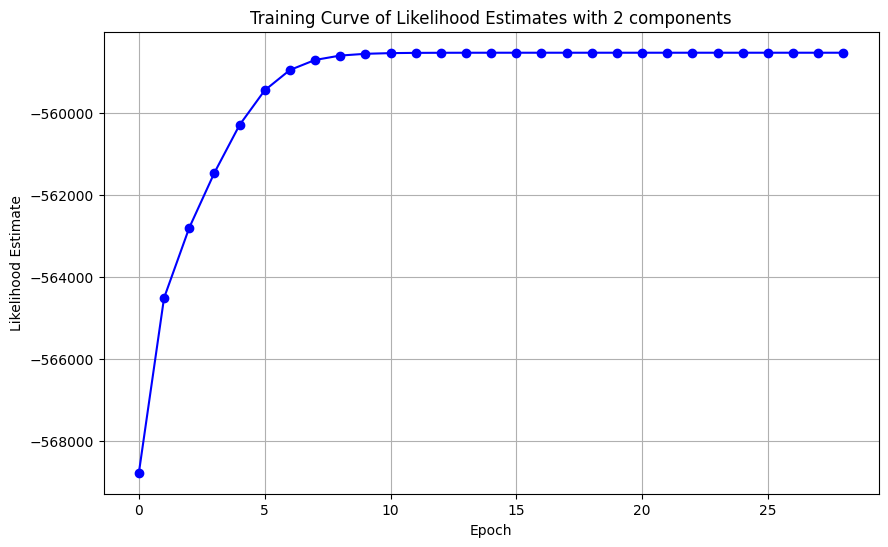

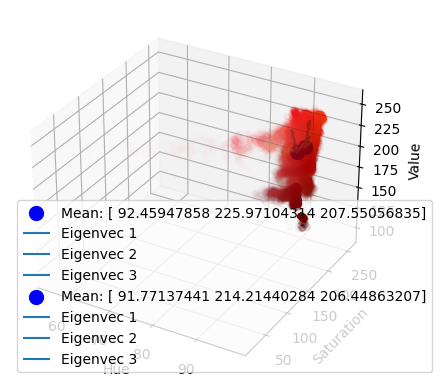

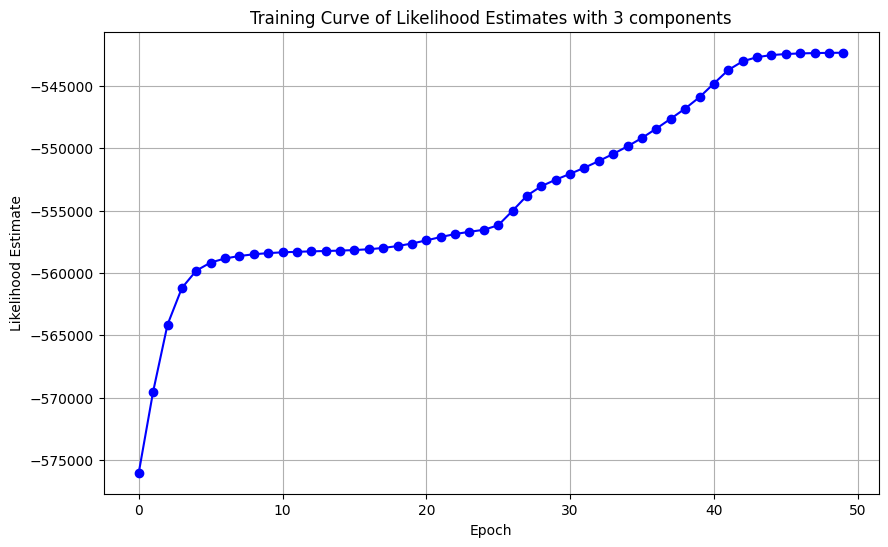

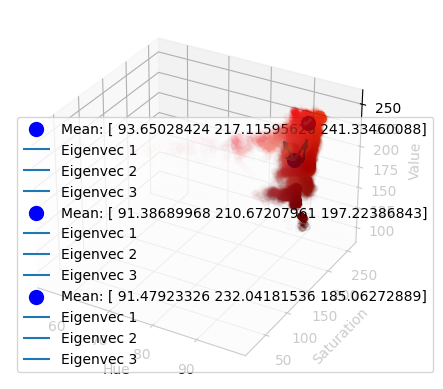

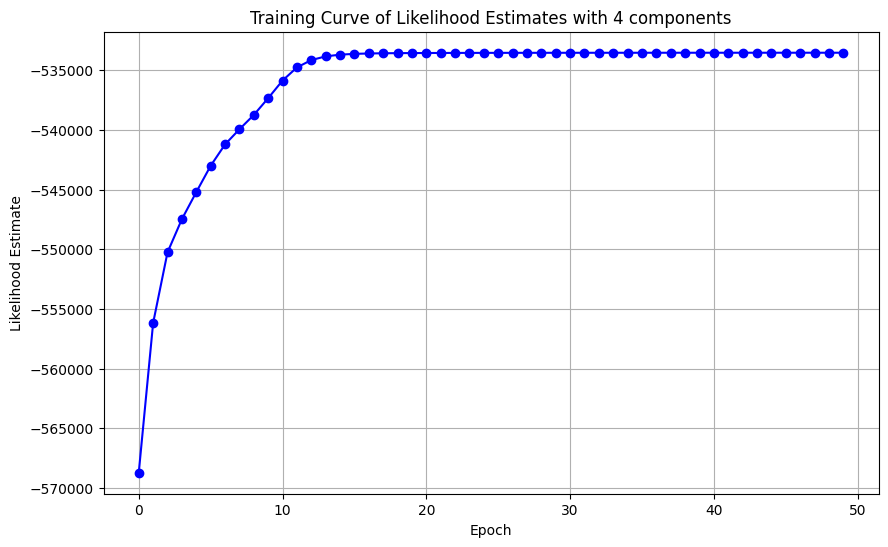

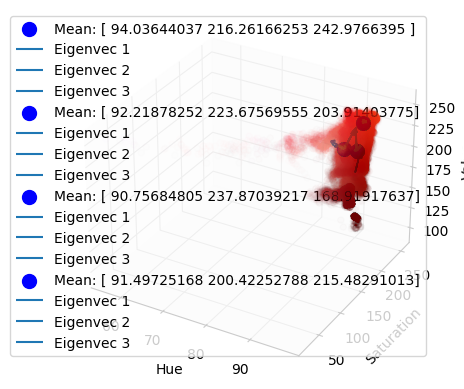

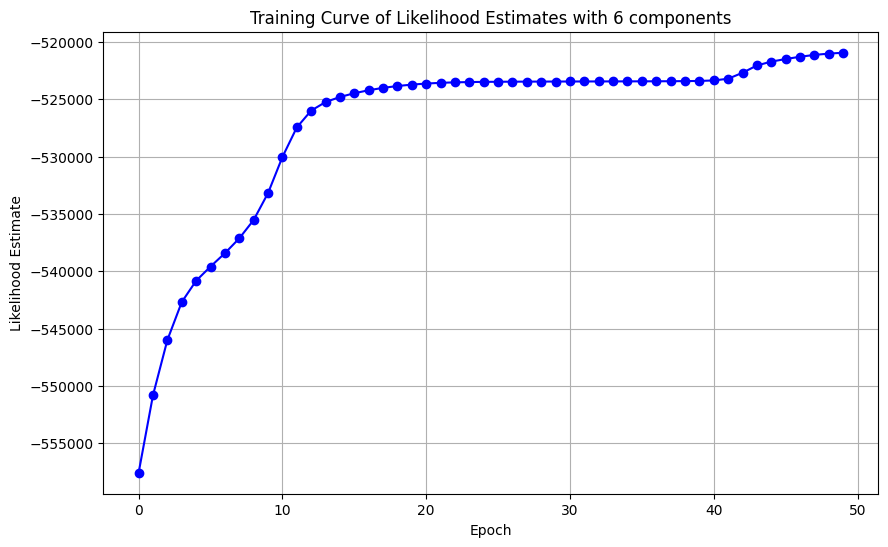

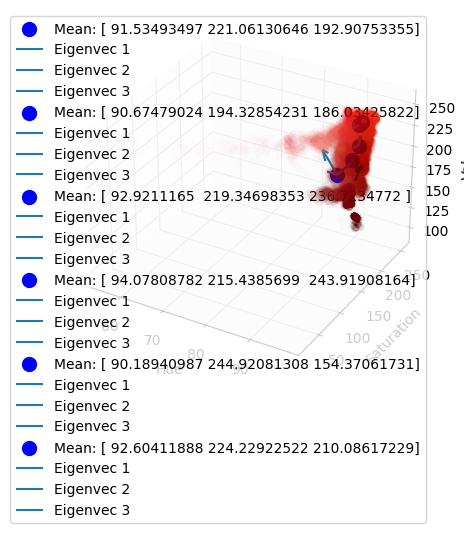

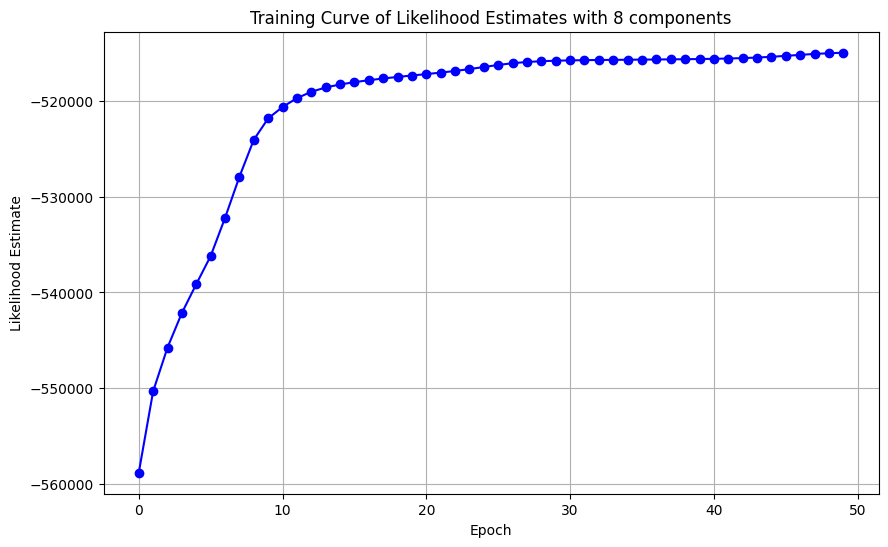

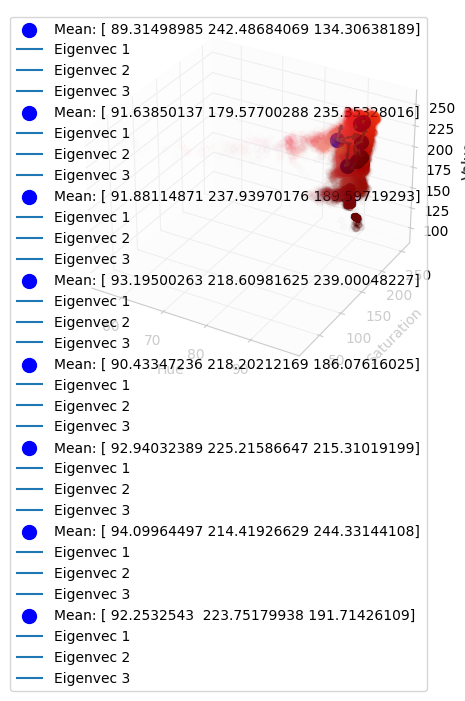

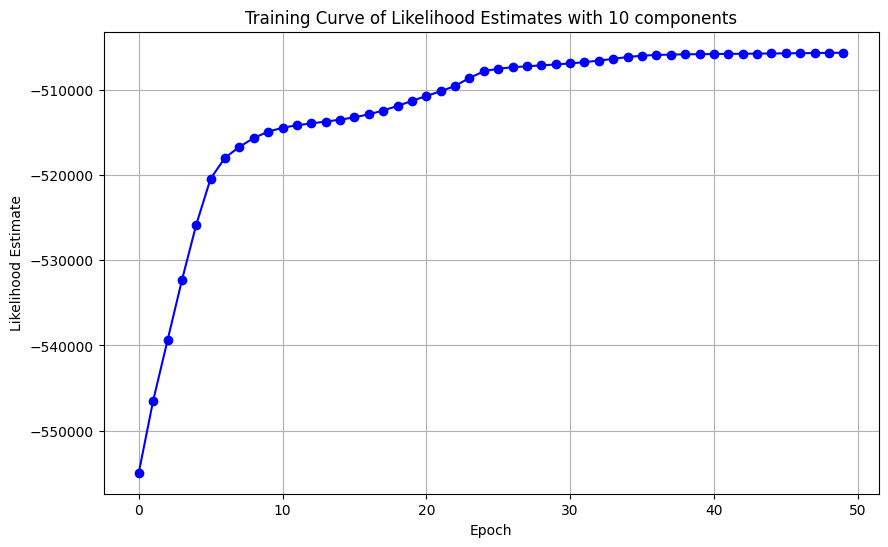

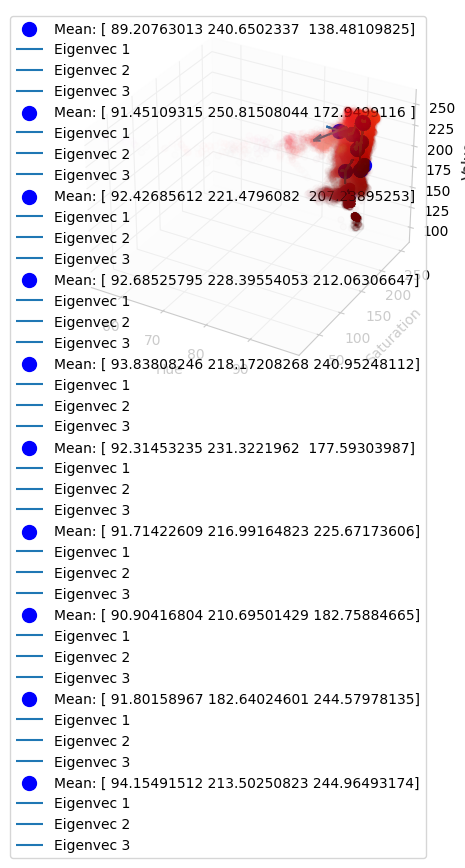

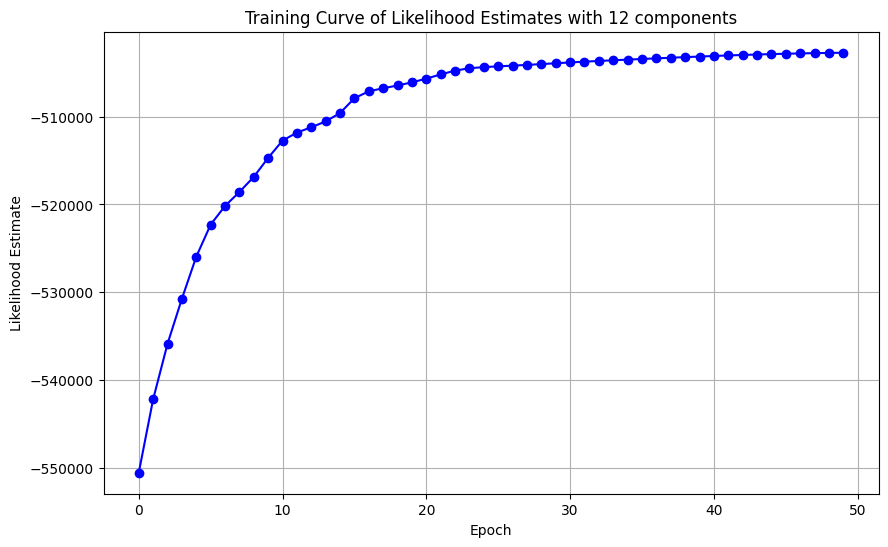

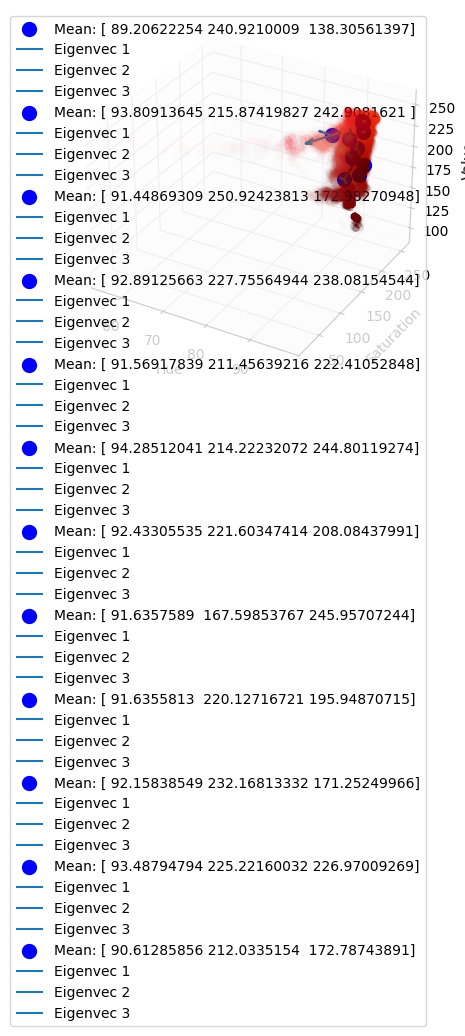

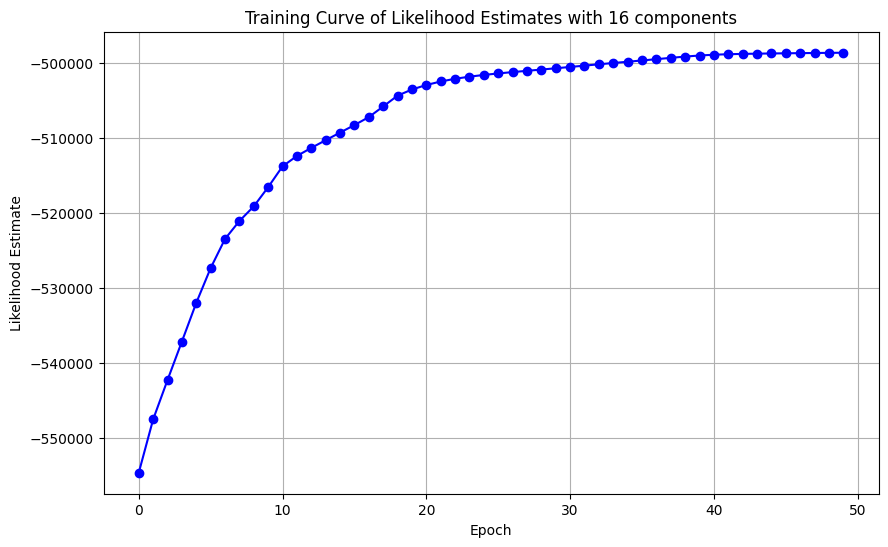

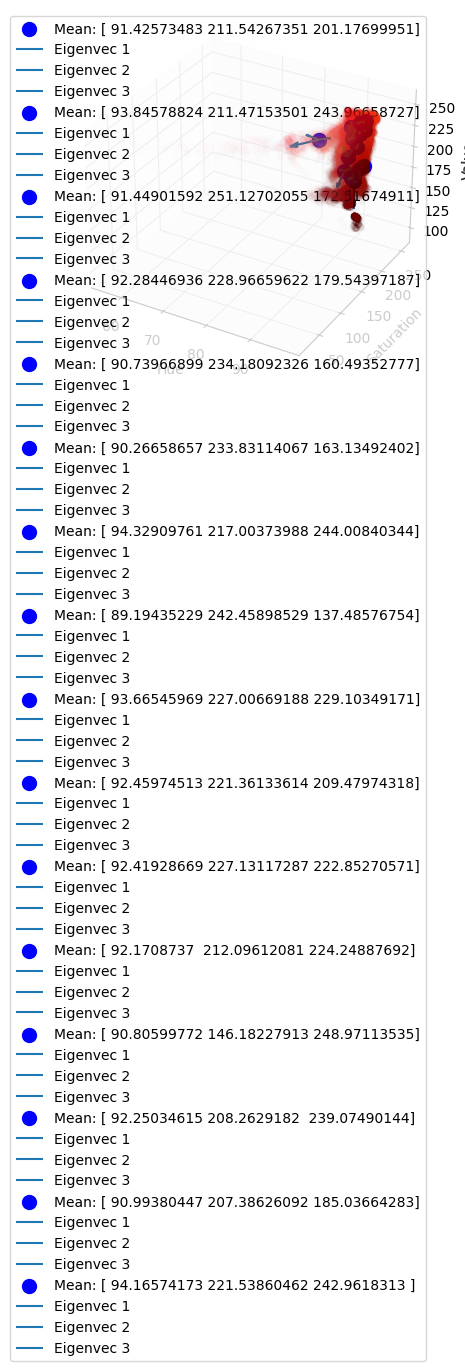

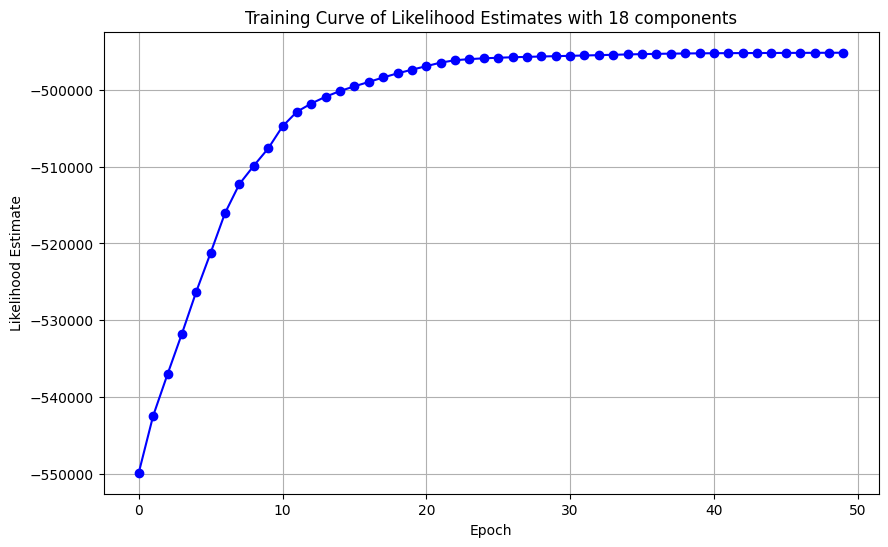

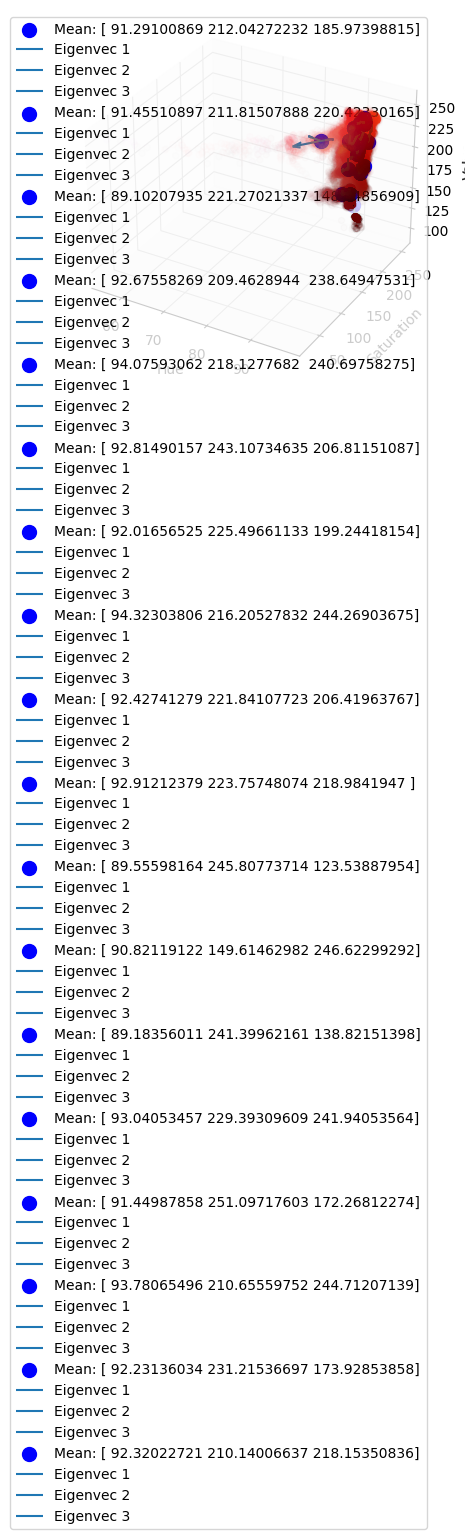

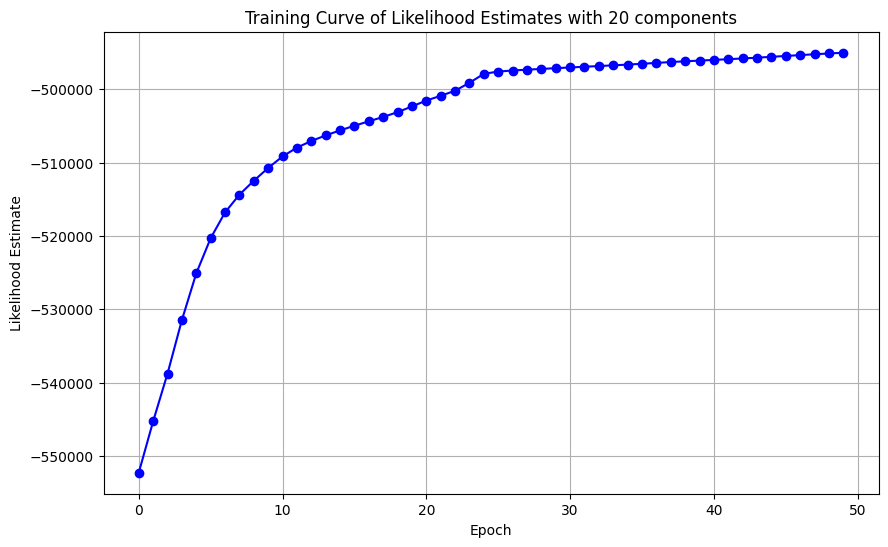

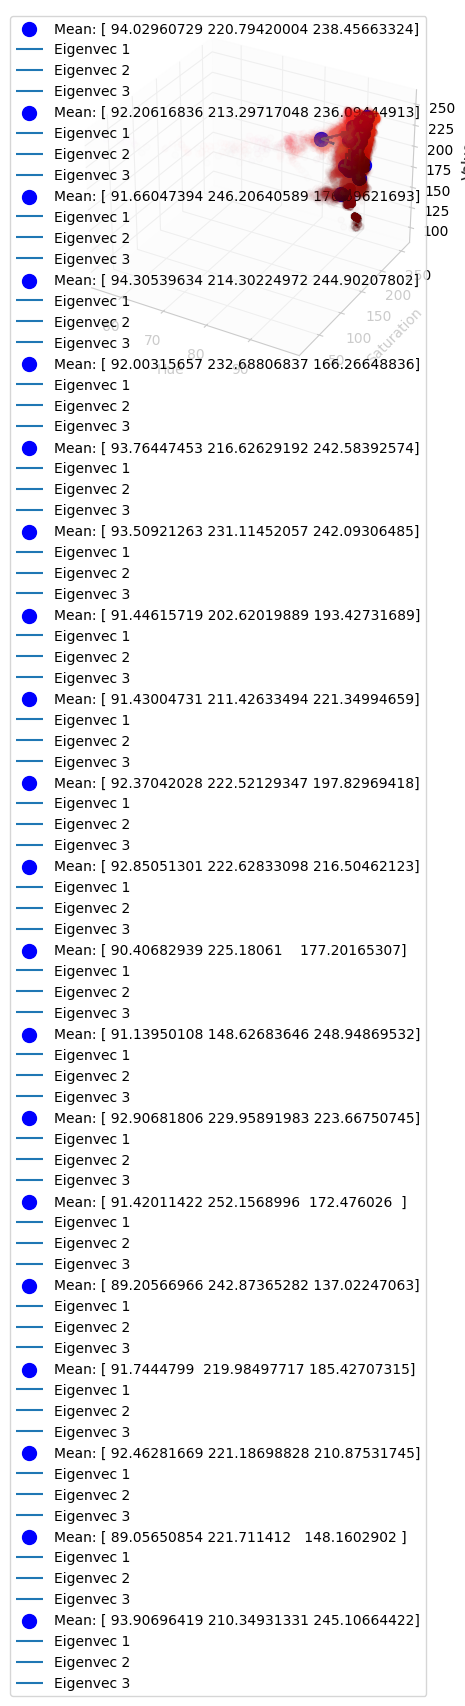

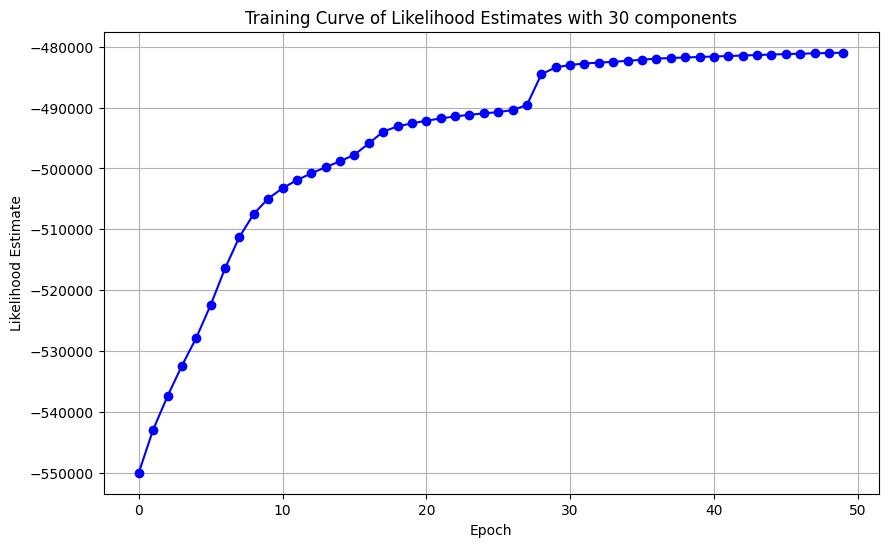

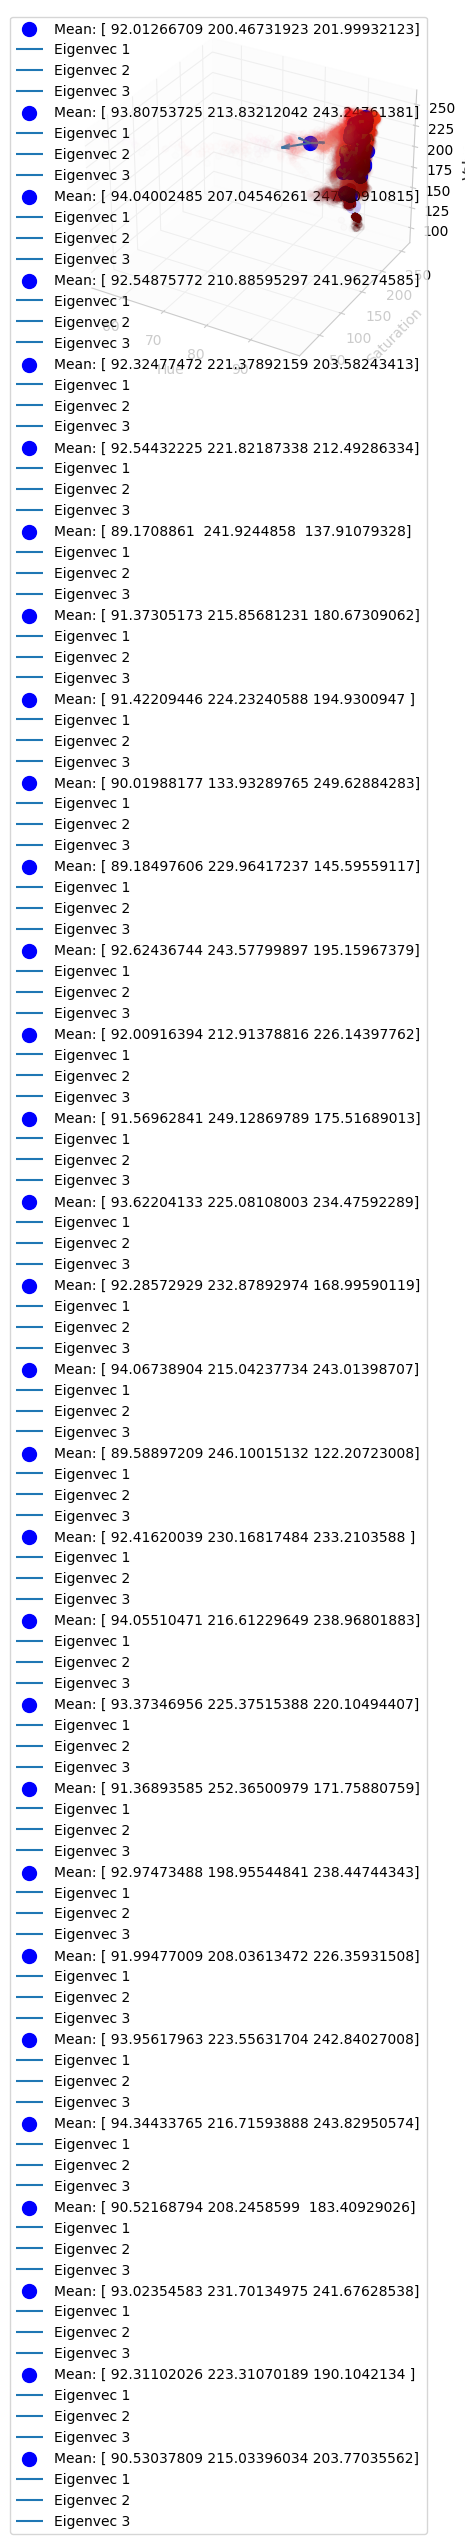

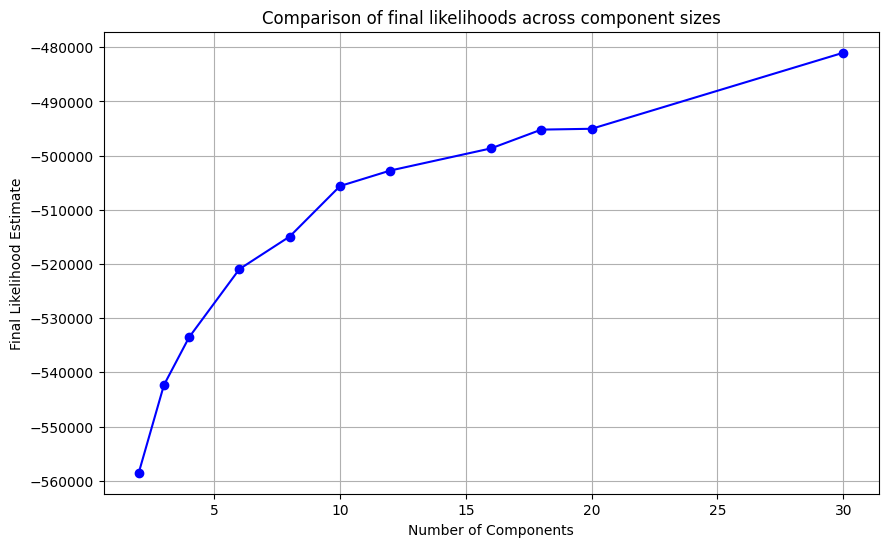

In [31]:
# Gaussian mixture model
tolerance = 1e-6 # TODO: figure out good tolerance
n = len(data)
num_epochs = 50

component_lhood_comp_dict = {}
lookup_tables = {}
print("Data: ", data)
print("\n")

components_list = [2, 3, 4, 6, 8, 10, 12, 16, 18, 20, 30]
# components_list = [8, 12, 20, 30]
# components_list = [12, 16]

for k in components_list:
    # Initialize mu and Sigma
    # mu = (255 * np.random.rand(k, 3)).astype(np.float64)
    # mu[:, 0] *= (180.0 / 255.0)
    # print(mu)
    # Sigma = (np.ones((k, 3, 3)) * np.eye(3)).astype(np.float64)
    mu = data.copy()[np.random.choice(n, k, replace=False)].astype(np.float64)
    Sigma = np.array([np.cov(data.T) + np.eye(3) * 1e-6 for _ in range(k)]).astype(np.float64)
    ## TODO: initialize with k_means
    
    
    print('initial mu: ', mu)
    print('initial Sigma: ', Sigma)

    g = gaussian(data, mu, Sigma, n, k)
    likelihood_list = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch}!\n")
        
        #### E step ####
        # log_g = log_gaussians(data, mu, Sigma)
        # # old code
        # g = np.zeros((n, num_g))
        # for i, x in enumerate(data): # NOTE: this could be broadcastable maybe
        #     for k in range(num_g):
        #         g[i,k] = gaussian3x3(x, mu[k], Sigma[k])
        
        # print("g after computing gaussians: ", g)

        # sum up gs along k axis and then divide g by sum to get z
        print('g shape at start of E: ', np.shape(g))
        print("g:", g)
        z_denom = np.sum(g, axis=1) # sum over k (clusters)
        z_denom = np.reshape(z_denom, (n, 1))
        print('z_denom shape: ', np.shape(z_denom))
        print('z_denom: ', z_denom)
        z = g / z_denom # z should be n x k matrix
        print("z shape: ", np.shape(z))
        print("z: ", z)
        # print('z after E step: ', z)
        assert np.shape(z) == (n, k)

        ##### TODO: check that ___ is adding up to one
        print("Are these all one?: ", np.sum(z, axis=1))
                
        #### M STEP ######
        z_k = np.sum(z, axis = 0).reshape(k, 1) # sum over i (data points)
        print("z_k shape: ", z_k.shape)
        print("z_k: ", z_k.shape)
        
        #### calculating new mu
        mu = z.T @ data
        mu = mu / z_k # mu should be k x 3 matrix
        assert mu.shape == (k, 3)

        #### TODO: try new dataset

        ##### calculating new Sigma
        print("xs shape: ", data.shape)
        print("mu shape: ", mu.shape)

        diffs = data.reshape(n, 1, 3) - mu  # Shape (n, k, 3), broadcasting xs over mus
        assert np.shape(diffs) == (n, k, 3)
        # for k_i in range(k):
        #     Sigma[k_i] = calculate_sigma_k(data, mu[k_i], z[:, k_i], z_k[k_i]) + (np.eye(k) * 1e-6)
        Sigma = np.array([calculate_sigma_k(data, mu[k_i], z[:, k_i], z_k[k_i]) + (np.eye(3) * 1e-6) for k_i in range(k)])
        print("New Sigmas: ", Sigma)
        print("New Sigmas shape: ", Sigma.shape)


        #### check for convergence ####
        # observing change in likelihood:
        # first calculate new gaussians for inputs given new params
        g = gaussian(data, mu, Sigma, n, k) # TODO: make sure inputs are correct shape first
        # calculate likelihood
        likelihood = calc_loglikelihood_g(g, z, use_weights=False)
        print(f"\nEpoch {epoch} likelihood: {likelihood}")

        likelihood_list.append(likelihood)

        if epoch > 0:
            # compare with previous likelihood
            if abs(likelihood - likelihood_list[-2]) < tolerance:
                # stop iterating, convergence is enough
                print("\nTOLERANCE HIT\n")
                break
        

        # # old version: checking for change in parameters
        # if old_mu and old_Sigma and old_z:
        #     mu_change = np.linalg.norm(old_mu - mu) # check this math
        #     Sigma_change = sum(np.linalg.norm(old_Sigma[k] - Sigma[k]) for k in range(len(old_Sigma))) # check this math
        #     z_change = np.linalg.norm(old_z - z_k)
        #     total_change = mu_change + Sigma_change + z_change
        #     if total_change < tolerance:
        #         break

        # # update old values
        # old_mu, old_Sigma, old_z = mu.copy(), Sigma.copy(), z_k.copy()

    # add the "converged" likelihood to the dictionary for comparing component hyperparameter later        
    component_lhood_comp_dict[k] = likelihood_list[-1]

    ## TODO: make training graph
    print('LIKELIHOOD LIST', likelihood_list)
    plot_training_curve(likelihood_list, k)

    ## TODO: graph mus and sigmas on data
    plot_params(data, mu, Sigma)

    ## TODO: make lookup table using most recent gaussian prediction
    # lt = create_lookup_table(mu, Sigma)
    # np.save(f'lookup_table_{k}_components.npy', lt)
    # lookup_tables[k] = lt

    print(f"\n Ending Epoch is {epoch}!\n")

    print(f'mu: {mu}, Sigma: {Sigma}, z_k: {z_k}')  

# TODO: make comparison graph across components
plot_comparison_curve(component_lhood_comp_dict) 

In [26]:

lt = create_lookup_table(mu, Sigma)
np.save(f'lookup_table_{30}_components.npy', lt)
# lookup_tables[k] = lt
# print(lookup_tables)
# print(np.max(lookup_tables[12]))